In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import plotly.express as px
import pickle

## Open Data and Join Data

In [97]:
data_train = pd.read_csv("data/train.csv")
data_store = pd.read_csv("data/store.csv")
dt = data_train.merge(data_store, left_on='Store', right_on='Store', how="left")

/Users/selbo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.



## Clean Data

In [98]:
dt.Open.fillna(1, inplace=True)
dt.Open.isnull().sum()

#remove all without Store
dt = dt.dropna( how='any', subset=['Store'])
#Make a variable ReOPENING that 1 one if a shop opens after 5 days of absence
#make a variable BIG reopening that is 1 after a shop open after 10 days of absence
dt['Open_5']  = dt.groupby('Store')['Open'].transform(lambda x: x.rolling(5,  min_periods=5).mean())
dt['Open_last5'] = dt.groupby('Store')['Open_5'].shift(1)
dt['Open_10']  = dt.groupby('Store')['Open'].transform(lambda x: x.rolling(10,  min_periods=5).mean())
dt['Open_last10'] = dt.groupby('Store')['Open_10'].shift(1)

dt['Reopening'] = (dt.Open_last5 == 0) & (dt.Open == 1)
dt['Reopening_big'] = (dt.Open_last10 == 0) & (dt.Open == 1)

dt.Open[dt.Open_last5 == 0].value_counts()
dt[dt.Store==2].head(60)
dt.Reopening_big.value_counts()

False    618415
True         58
Name: Reopening_big, dtype: int64

In [99]:
#Drop the Customers because we will not have it in the Future
dt = dt.drop("Customers", axis=1)

In [100]:
#Date Variable format
dt['Date'] = pd.DatetimeIndex(dt['Date']) 

In [101]:
#Missing variables in the beginning
dt.isnull().sum()

Date                              0
Store                             0
DayOfWeek                     18437
Sales                         18445
Open                              0
Promo                         18682
StateHoliday                  18600
SchoolHoliday                 18787
StoreType                         0
Assortment                        0
CompetitionDistance            1635
CompetitionOpenSinceMonth    196430
CompetitionOpenSinceYear     196430
Promo2                            0
Promo2SinceWeek              303645
Promo2SinceYear              303645
PromoInterval                303645
Open_5                         4460
Open_last5                     5575
Open_10                        4460
Open_last10                    5575
Reopening                         0
Reopening_big                     0
dtype: int64

## Exploratory Analysis

In [102]:
dt.StateHoliday.value_counts()

0      519485
0.0     61649
a       12425
b        4205
c        2109
Name: StateHoliday, dtype: int64

## Get rid of missing Stores (they miss too many features)

In [103]:
#at this get rid of missing store
dt = dt.dropna( how='any', subset=["Store"])
#also change to INTEGER
dt.loc[:, "Store"] = dt.loc[:, "Store"].astype(int)

In [104]:
dt_full = dt

## Exploratory Graph

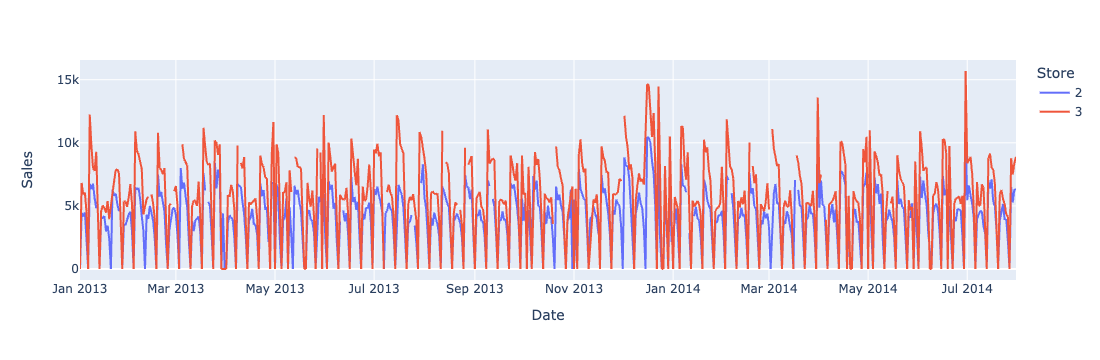

In [105]:

#dt_full.loc[:, "Monday"] = dt_full.loc[:, "DayOfWeek"]==1
shop2 = (dt_full.loc[:, "Store"]==2) | (dt_full.loc[:, "Store"]==3) 
#shop2 = (dt_full.loc[:, "Store"]==3) 

px.line(dt_full[shop2], x="Date", y="Sales",  color='Store')
#px. add_line(dt_full[shop2], x="Date", y="Sales")
#, animation_frame="year", ,size="pop", color="continent", hover_name="country",log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90]

# Feature Engineering

In [106]:
#make one-hot-encoding for the StateHoliday variable
#a = public holiday, b = Easter holiday, c = Christmas, 0 = None
dt_eng = dt
dt_eng.loc[: , "PublicHoliday"] = dt.loc[:, "StateHoliday"]=="a" 
dt_eng.loc[: , "Easter"] = dt.loc[:, "StateHoliday"]=="b" 
dt_eng.loc[: , "Christmas"] = dt.loc[:, "StateHoliday"]=="c" 
#dt_eng = dt.drop("StateHoliday", axis=1)


In [107]:
#StoreType One-Hot encoding
dummies = pd.get_dummies(dt.loc[:, "StoreType"], prefix="storetype", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [108]:
#Storetype Mean encoding

#i dont want the 0 sales days (and missing values) have an effect on the averaging... therefore i make a little sz dataframe that drops these values
sz = dt_eng.dropna( how='any', subset=['Sales'])
sales_zeros=(sz["Sales"] == 0)
sz = sz.loc[~sales_zeros, :]

#i use the sz in the groupby
dt_eng = dt_eng.join(sz.groupby("StoreType")["Sales"].mean(), how="left", on="StoreType", rsuffix="_avg_storetype")

In [109]:
#Store Fixed-Effects
#i use the sz again to have the 0 days not affect the mean and median
dt_eng = dt_eng.join(sz.groupby("Store")["Sales"].mean(), how="left", on="Store", rsuffix="_avg_store")
dt_eng = dt_eng.join(sz.groupby("Store")["Sales"].median(), how="left", on="Store", rsuffix="_median_store")

dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Open_5',
       'Open_last5', 'Open_10', 'Open_last10', 'Reopening', 'Reopening_big',
       'PublicHoliday', 'Easter', 'Christmas', 'storetype_a', 'storetype_b',
       'storetype_c', 'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store'],
      dtype='object')

### Save our mean encodings for the Store_Sales

In [110]:
x = dt_eng.groupby("Store").mean()
x = x.loc[:, "Sales_avg_store"]
data_temp = pd.read_csv("data/store.csv")
data_temp = data_temp.merge(x, how='left', on=None, left_on="Store", right_on=None, left_index=False, right_index=True)
data_temp.to_csv(path_or_buf="data/store_AnSeb.csv")

## go on feature engineering

In [111]:
#Assortment
#dt_eng.groupby("Assortment").mean()['Sales']
dummies = pd.get_dummies(dt_eng.loc[:, "Assortment"], prefix="assort", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [112]:
dt_eng.columns

Index(['Date', 'Store', 'DayOfWeek', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'Open_5',
       'Open_last5', 'Open_10', 'Open_last10', 'Reopening', 'Reopening_big',
       'PublicHoliday', 'Easter', 'Christmas', 'storetype_a', 'storetype_b',
       'storetype_c', 'storetype_d', 'Sales_avg_storetype', 'Sales_avg_store',
       'Sales_median_store', 'assort_a', 'assort_b', 'assort_c'],
      dtype='object')

### put in interactions

In [113]:
#do different store types react differently to christmas?
#plt.bar(dt_eng["DayOfWeek"], height=dt_eng["Sales"])
#plt.show()

In [114]:
#import plotly.express as px
#fig = px.bar(dt_eng, x='year', y='pop')
#fig.show()

In [115]:
#Storetypes reacting to Christmas
dt_eng.loc[:, "SAXmas"] = dt_eng.storetype_a * dt_eng.Christmas
dt_eng.loc[:, "SBXmas"] = dt_eng.storetype_b * dt_eng.Christmas
dt_eng.loc[:, "SCXmas"] = dt_eng.storetype_c * dt_eng.Christmas
dt_eng.loc[:, "SDXmas"] = dt_eng.storetype_d * dt_eng.Christmas

dt_eng.loc[:, "logDistance"] = np.log(dt_eng.loc[:, "CompetitionDistance"])

## Drop the Sales = 0 (after feature engineering)

In [116]:
dt_eng = dt_eng.dropna( how='any', subset=['Sales'])
sales_zeros=(dt_eng["Sales"] == 0)
dt_eng = dt_eng.loc[~sales_zeros, :]

## Impute some Vaues

In [117]:
#impute the School Holiday
dt_eng["SchoolHoliday"] = dt_eng["SchoolHoliday"].fillna(0)
dt_eng['CompetitionDistance'] = dt_eng['CompetitionDistance'].fillna(dt_eng['CompetitionDistance'].mean())
dt_eng['logDistance'] = dt_eng['logDistance'].fillna(dt_eng['logDistance'].mean())

### time series stuff

In [118]:
#MOVING 7 day average (but i think we will not have this fpr the prediction so i dont use it)
#dt_eng['Sales_MA7'] = 
dt_eng = dt_eng.dropna( how='any', subset=["Store"])
#Moving Average 7 day
#dt_eng['Sales_MA7'] = dt_eng.groupby('Store')['Sales'].transform(lambda x: x.rolling(7, 1).mean())


In [119]:
##Add Monthly Fixed Effects
dt_eng['day'] = pd.DatetimeIndex(dt_eng['Date']).day
dt_eng['month'] = pd.DatetimeIndex(dt_eng['Date']).month
dt_eng['week'] = pd.DatetimeIndex(dt_eng['Date']).week
dt_eng['year'] = pd.DatetimeIndex(dt_eng['Date']).year

<ipython-input-119-907aadee8390>:4: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



In [120]:
dummies = pd.get_dummies(dt_eng.loc[:, "month"], prefix="m", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)


In [121]:
dt_eng = dt_eng.dropna( how='any', subset=["DayOfWeek"])
dummies = pd.get_dummies(dt_eng.loc[:, "DayOfWeek"].astype(int), prefix="dow", prefix_sep='_')
dt_eng = pd.concat([dt_eng, dummies], axis=1)

In [122]:
#Beginning of the month craze
dt_eng["monthstart"] = (dt_eng.day>=30) | ( dt_eng.day<=3)

In [123]:
#i want to have a promo counter. i assume that a promo is effective for 1 month (30 days). If a new Promo2 starts, it is set to 30 and then decreases daily
#if the promo is 
store23 = (dt_eng.loc[:, "Store"]==30)

dt_eng["prstart"] = (dt_eng.Promo2SinceWeek <= dt_eng.week) & (dt_eng.Promo2SinceYear <= dt_eng.year)


In [124]:
dt_eng = pd.concat([dt_eng, dt_eng["PromoInterval"].str.split(',', expand=True)], axis=1)

In [125]:
def mnames(s):
    if s=="Jan":
        return 1
    if s=="Feb":
        return 2
    if s=="Mar":
        return 3
    if s=="Apr":
        return 4
    if s=="May":
        return 5
    if s=="Jun":
        return 6
    if s=="Jul":
        return 7
    if s=="Aug":
        return 8
    if s=="Sept":
        return 9
    if s=="Oct":
        return 10
    if s=="Nov":
        return 11
    if s=="Dec":
        return 12

In [126]:
dt_eng.loc[:, 'pr1'] = dt_eng.loc[:, 0].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr2'] = dt_eng.loc[:, 1].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr3'] = dt_eng.loc[:, 2].apply(lambda row : mnames(row))
dt_eng.loc[:, 'pr4'] = dt_eng.loc[:, 3].apply(lambda row : mnames(row))

dt_eng.loc[:, "themonth"] = (dt_eng['pr1'] == dt_eng["month"])|(dt_eng['pr2'] == dt_eng["month"])|(dt_eng['pr4'] == dt_eng["month"])|(dt_eng['pr3'] == dt_eng["month"])  
dt_eng["pr_campaign"] = (dt_eng['prstart']==True) & (dt_eng["themonth"] == True)
dt_eng.loc[:, ["month", "pr1", "pr2", "pr3", "pr4", "themonth", "pr_campaign", "prstart"]]                
#dt_eng["pr_campaign"].value_counts()

,month,pr1,pr2,pr3,pr4,themonth,pr_campaign,prstart
27,1,2.0,5.0,8.0,11.0,False,False,False
115,1,1.0,4.0,7.0,10.0,True,False,False
147,1,3.0,6.0,9.0,12.0,False,False,False
162,1,NaN,NaN,NaN,NaN,False,False,False
199,1,NaN,NaN,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...
637768,7,1.0,4.0,7.0,10.0,True,True,True
637769,7,2.0,5.0,8.0,11.0,False,False,True
637771,7,3.0,6.0,9.0,12.0,False,False,True
637772,7,NaN,NaN,NaN,NaN,False,False,False


In [127]:
# Make a Variable that counts the days since day 1
dt_eng['Date'] = pd.to_datetime(dt_eng['Date']) 

dt_eng['date_delta'] = (dt_eng['Date'] - dt_eng['Date'].min())  / np.timedelta64(1,'D')
#dt_eng

In [128]:
#Define 'City_Center' =1 if distance <800 & competition open since year <2004
dt_eng['City_center'] = (dt_eng['CompetitionDistance'] < 500) &(dt_eng['CompetitionOpenSinceYear'] < 2004)
dt_eng.City_center.value_counts()

False    475220
True       7346
Name: City_center, dtype: int64

In [129]:
#checkoing the data, one can see that in uneven weeks the first 3 days are selling especially well, this is one way to make it
dt_eng['week1'] = ((dt_eng['week'] % 4) == 0) 
dt_eng['week3'] = ((dt_eng['week'] % 4) == 2)
dt_eng['week13'] = ((dt_eng['week'] % 4) == 0) | ((dt_eng['week'] % 4) == 2)
dt_eng['week13'].value_counts()
dt_eng['firstdaysweek13'] = ((dt_eng['week13']) == True) & (dt_eng['DayOfWeek'] < 4 )

In [130]:
#another way is to code the weekdays separately.... 
dt_eng["Fortnight_Days"] = dt_eng["DayOfWeek"]
dt_eng.Fortnight_Days.value_counts()
dt_eng.loc[dt_eng['week13']==True, "Fortnight_Days"] = dt_eng["Fortnight_Days"] * 2 
dt_eng.Fortnight_Days.value_counts()


4.0     81666
6.0     80508
2.0     80235
12.0    41272
3.0     41082
5.0     40302
10.0    39728
1.0     39261
8.0     36507
14.0     1003
7.0      1002
Name: Fortnight_Days, dtype: int64

## Final Feature selection

In [131]:
dt_eng.columns

Index([                     'Date',                     'Store',
                       'DayOfWeek',                     'Sales',
                            'Open',                     'Promo',
                    'StateHoliday',             'SchoolHoliday',
                       'StoreType',                'Assortment',
             'CompetitionDistance', 'CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear',                    'Promo2',
                 'Promo2SinceWeek',           'Promo2SinceYear',
                   'PromoInterval',                    'Open_5',
                      'Open_last5',                   'Open_10',
                     'Open_last10',                 'Reopening',
                   'Reopening_big',             'PublicHoliday',
                          'Easter',                 'Christmas',
                     'storetype_a',               'storetype_b',
                     'storetype_c',               'storetype_d',
             'Sales_avg_s

In [132]:
dic = {7: 1, 1: 2, 2:3, 3:4, 4:5, 5: 6 , 6: 7}
dt_eng['DayOfWeek_recode'] = dt_eng['DayOfWeek'].replace(dic)

dt_eng[['DayOfWeek', "DayOfWeek_recode"]]

,DayOfWeek,DayOfWeek_recode
27,2.0,3.0
115,2.0,3.0
147,2.0,3.0
162,2.0,3.0
199,2.0,3.0
...,...,...
637768,4.0,5.0
637769,4.0,5.0
637771,4.0,5.0
637772,4.0,5.0


In [133]:

features = [ "Store", 'SchoolHoliday', 'logDistance', 'prstart', 'Promo2', 'PublicHoliday', 'Easter', 'Christmas' 
            , 'Sales_avg_store', 'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c',
            "monthstart", "date_delta", "City_center", "firstdaysweek13", 
           "m_12", "Fortnight_Days", "DayOfWeek_recode",
           "dow_1", "dow_5", "dow_6",  "dow_2", "dow_3", "dow_4","dow_7" , "pr_campaign", "Reopening"]


In [134]:
#dt_eng[features].isnull().sum()

In [135]:
dt_eng_nomissing = dt_eng.dropna( how='any', subset=features)
X = dt_eng_nomissing.loc[:, features ]
y = dt_eng_nomissing.loc[:, 'Sales']

In [136]:
#X.isnull().sum()

In [137]:
#import plotly.express as px
#fig = px.scatter(X.loc[:, "DayOfWeek"], y)
#fig.show()

In [138]:
X.count()

Store               482566
SchoolHoliday       482566
logDistance         482566
prstart             482566
Promo2              482566
PublicHoliday       482566
Easter              482566
Christmas           482566
Sales_avg_store     482566
storetype_a         482566
storetype_b         482566
storetype_c         482566
storetype_d         482566
assort_a            482566
assort_b            482566
assort_c            482566
monthstart          482566
date_delta          482566
City_center         482566
firstdaysweek13     482566
m_12                482566
Fortnight_Days      482566
DayOfWeek_recode    482566
dow_1               482566
dow_5               482566
dow_6               482566
dow_2               482566
dow_3               482566
dow_4               482566
dow_7               482566
pr_campaign         482566
Reopening           482566
dtype: int64

## Split Data in Test/Train

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, train_size=0.80, random_state=42, shuffle=True, stratify=X["Store"])

In [140]:
X_train = X_train.drop("Store", axis=1)
X_test = X_test.drop("Store", axis=1)
X = X.drop("Store", axis=1)

In [141]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [142]:
def rmspe(preds, actuals):
    #preds = preds.reshape(-1)
    #actuals = actuals.reshape(-1)
    #assert preds.shape == actuals.shape
    return np.sqrt(np.mean(np.square((actuals-preds) / actuals))) * 100

In [143]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=3
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [144]:
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [1000],
    'learning_rate' : [0.1],
    'colsample_bytree': [0.7],
    'max_depth': [5],
    'reg_alpha': [1.1],
    'reg_lambda': [1.3],
    'subsample': [0.9]
}



model, pred = algorithm_pipeline(X, X_test, y, y_test, model, 
                                 param_grid, cv=10)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
1645.9455567224413
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 1.1, 'reg_lambda': 1.3, 'subsample': 0.9}


In [145]:
rmspe(model.predict(X_test), y_test)

15.505607655510964

In [ ]:
Index(['Store', 'SchoolHoliday', 'logDistance', 'prstart', 'Promo2',
       'PublicHoliday', 'Easter', 'Christmas', 'Sales_avg_store',
       'storetype_a', 'storetype_b', 'storetype_c', 'storetype_d', 'assort_a',
       'assort_b', 'assort_c', 'monthstart', 'date_delta', 'City_center',
       'firstdaysweek13', 'm_12', 'Fortnight_Days', 'DayOfWeek_recode',
       'dow_1', 'dow_5', 'dow_6', 'dow_2', 'dow_3', 'dow_4', 'dow_7',
       'pr_campaign', 'Reopening'],

In [149]:
X_train.columns

Index(['SchoolHoliday', 'logDistance', 'prstart', 'Promo2', 'PublicHoliday',
       'Easter', 'Christmas', 'Sales_avg_store', 'storetype_a', 'storetype_b',
       'storetype_c', 'storetype_d', 'assort_a', 'assort_b', 'assort_c',
       'monthstart', 'date_delta', 'City_center', 'firstdaysweek13', 'm_12',
       'Fortnight_Days', 'DayOfWeek_recode', 'dow_1', 'dow_5', 'dow_6',
       'dow_2', 'dow_3', 'dow_4', 'dow_7', 'pr_campaign', 'Reopening'],
      dtype='object')

In [147]:
# save the model to disk 
pickle.dump(model, open('model_AnSeb2.sav', 'wb'))